# Deep Learning for Diabetes Detection Using Kolmogorov-Arnold Networks
## By Erin Gregoire, Daniel Viola, & Dawson Damuth
### July 2025

In [122]:
import pandas as pd
import matplotlib.pyplot as plt
import time
import numpy as np
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import copy
import os

import torch
from torch.utils.data import TensorDataset, DataLoader
import torchinfo
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from KAN import KANLayer, CubicSpline


In [123]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'using device: {device}')

using device: cpu


### Data Import & Preprocessing

In [127]:
import kagglehub
path = kagglehub.dataset_download("alexteboul/diabetes-health-indicators-dataset")
files = os.listdir(path)
print(files)
data = pd.read_csv(os.path.join(path, files[1]))

['diabetes_012_health_indicators_BRFSS2015.csv', 'diabetes_binary_health_indicators_BRFSS2015.csv', 'diabetes_binary_5050split_health_indicators_BRFSS2015.csv']


In [128]:
numerical_features = ['BMI', 'GenHlth', 'MentHlth', 'PhysHlth', 'Age']
binary_features = ['HighBP', 'HighChol', 'CholCheck', 'Smoker', 'Stroke',
                   'HeartDiseaseorAttack', 'PhysActivity', 'Fruits',
                   'NoDocbcCost', 'DiffWalk', 'Sex']
categorical_features = ['Education', 'Income']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('bin', 'passthrough', binary_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)])

X = data.drop('Diabetes_binary', axis=1)
y = data['Diabetes_binary']

X_processed = preprocessor.fit_transform(X)

X_train, X_temp, y_train, y_temp = train_test_split(
    X_processed, y, test_size=0.2, random_state=676, stratify=y)
X_test, X_val, y_test, y_val = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=676, stratify=y_temp)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).view(-1, 1)

batch_size = 256
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print('X train:', X_train.shape, '| y train:', y_train.shape)
print('X validation:', X_val.shape, '| y validation:', y_val.shape)
print('X test:', X_test.shape, '| y test:', y_test.shape)

X train: (202944, 30) | y train: (202944,)
X validation: (25368, 30) | y validation: (25368,)
X test: (25368, 30) | y test: (25368,)


### KAN Architecture

In [133]:

class KAN2(nn.Module):
    def __init__(self, input_bounds=None):
        super().__init__()
        self.layer1=KANLayer(30,200, feature_bounds=input_bounds)
        self.layer2 = KANLayer(200,200)
        self.layer3=KANLayer(200,1)
        
    def forward(self,x):
        x=self.layer1(x)
        x=self.layer2(x)
        x=self.layer3(x)
        x=torch.sigmoid(x)
        return x

In [134]:
net = KAN2()
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(net.parameters(), lr=.001)

In [135]:
torchinfo.summary(net)

Layer (type:depth-idx)                   Param #
KAN2                                     --
├─KANLayer: 1-1                          --
│    └─ModuleList: 2-1                   --
│    │    └─CubicSpline: 3-1             50
│    │    └─CubicSpline: 3-2             50
│    │    └─CubicSpline: 3-3             50
│    │    └─CubicSpline: 3-4             50
│    │    └─CubicSpline: 3-5             50
│    │    └─CubicSpline: 3-6             50
│    │    └─CubicSpline: 3-7             50
│    │    └─CubicSpline: 3-8             50
│    │    └─CubicSpline: 3-9             50
│    │    └─CubicSpline: 3-10            50
│    │    └─CubicSpline: 3-11            50
│    │    └─CubicSpline: 3-12            50
│    │    └─CubicSpline: 3-13            50
│    │    └─CubicSpline: 3-14            50
│    │    └─CubicSpline: 3-15            50
│    │    └─CubicSpline: 3-16            50
│    │    └─CubicSpline: 3-17            50
│    │    └─CubicSpline: 3-18            50
│    │    └─CubicSpline: 3-

In [136]:
# after adding dropout layers
torchinfo.summary(net)

Layer (type:depth-idx)                   Param #
KAN2                                     --
├─KANLayer: 1-1                          --
│    └─ModuleList: 2-1                   --
│    │    └─CubicSpline: 3-1             50
│    │    └─CubicSpline: 3-2             50
│    │    └─CubicSpline: 3-3             50
│    │    └─CubicSpline: 3-4             50
│    │    └─CubicSpline: 3-5             50
│    │    └─CubicSpline: 3-6             50
│    │    └─CubicSpline: 3-7             50
│    │    └─CubicSpline: 3-8             50
│    │    └─CubicSpline: 3-9             50
│    │    └─CubicSpline: 3-10            50
│    │    └─CubicSpline: 3-11            50
│    │    └─CubicSpline: 3-12            50
│    │    └─CubicSpline: 3-13            50
│    │    └─CubicSpline: 3-14            50
│    │    └─CubicSpline: 3-15            50
│    │    └─CubicSpline: 3-16            50
│    │    └─CubicSpline: 3-17            50
│    │    └─CubicSpline: 3-18            50
│    │    └─CubicSpline: 3-

### Training the model

In [137]:
feature_bounds = [(float(X_train[:, i].min()), float(X_train[:, i].max())) for i in range(X_train.shape[1])]

net =KAN2(input_bounds=feature_bounds).to(device)
loss_fn =nn.BCELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=.001)

In [138]:
optimizer = torch.optim.Adam(net.parameters(), lr=.001, weight_decay=1e-4)
epochs = 1
epoch_number = 0

start_time = time.time()
for epoch in range(epochs):
    print(f'Epoch # {epoch_number+1}')

    net.train(True)
    running_loss = 0.0
    correct = 0
    total = 0
    
    for i, data in enumerate(train_loader):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.float().to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
    
        loss = loss_fn(outputs, labels)
        loss.backward() # compute gradients
        optimizer.step() # update weights
        running_loss += loss.item()
        
        preds = (outputs >= .5).float()
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_acc = (correct / total) * 100
    avg_loss = running_loss / len(train_loader)

    running_vloss = 0.0
    net.eval() # set to evaluation mode
    vcorrect = 0
    vtotal = 0

    with torch.no_grad():
        for i, vdata in enumerate(val_loader):
            vinputs, vlabels = vdata
            vinputs = vinputs.to(device)
            vlabels = vlabels.float().to(device)
            voutputs = net(vinputs)
            vloss = loss_fn(voutputs, vlabels)
            running_vloss += vloss.item()

            vpreds = (voutputs >= .5).float()
            vcorrect += (vpreds == vlabels).sum().item()
            vtotal += vlabels.size(0)

    val_acc = (vcorrect / vtotal) * 100
    avg_vloss = running_vloss / len(val_loader)
    
    print('Loss: training = {}, validation = {}'.format(avg_loss, avg_vloss))
    print('Accuracy: training = {}%, validation = {}%'.format(train_acc, val_acc))

    epoch_number += 1

end_time = time.time()
estimated_training_time = end_time - start_time
print(f'Estimated training time: {round(estimated_training_time/60, 2)} minutes')

Epoch # 1
Loss: training = 0.3342938412821759, validation = 0.3175500416755676
Accuracy: training = 86.2232931251971%, validation = 86.66035950804162%
Estimated training time: 1.92 minutes


### Save the Best Model

In [139]:
epochs = 10
epoch_number = 0
best_vloss = 1000000

best_train_loss = []
best_val_loss = []
best_train_accuracy = []
best_val_accuracy = []

start_time = time.time()
for epoch in range(epochs):
    print(f'Epoch # {epoch_number+1}')

    net.train(True)
    running_loss = 0.0
    correct = 0
    total = 0
    
    for i, data in enumerate(train_loader):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.float().to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
    
        loss = loss_fn(outputs, labels)
        loss.backward() # compute gradients
        optimizer.step() # update weights
        running_loss += loss.item()
        
        preds = (outputs >= .5).float()
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_acc = (correct / total) * 100
    avg_loss = running_loss / len(train_loader)
    best_train_loss.append(avg_loss)
    best_train_accuracy.append(train_acc)

    running_vloss = 0.0
    net.eval() # set to evaluation mode
    vcorrect = 0
    vtotal = 0

    with torch.no_grad():
        for i, vdata in enumerate(val_loader):
            vinputs, vlabels = vdata
            vinputs = vinputs.to(device)
            vlabels = vlabels.float().to(device)
            voutputs = net(vinputs)
            vloss = loss_fn(voutputs, vlabels)
            running_vloss += vloss.item()

            vpreds = (voutputs >= .5).float()
            vcorrect += (vpreds == vlabels).sum().item()
            vtotal += vlabels.size(0)

    val_acc = (vcorrect / vtotal) * 100
    avg_vloss = running_vloss / len(val_loader)
    best_val_loss.append(avg_vloss)
    best_val_accuracy.append(val_acc)
    
    print('Loss: training = {}, validation = {}'.format(avg_loss, avg_vloss))
    print('Accuracy: training = {}%, validation = {}%'.format(train_acc, val_acc))

    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        best_model = copy.deepcopy(net.state_dict())
        torch.save(best_model, 'project_KAN_dawsonda_dviola_ergregoi.pth')

    epoch_number += 1

end_time = time.time()
estimated_training_time = end_time - start_time
print(f'Estimated training time: {round(estimated_training_time/60, 2)} minutes')

Epoch # 1
Loss: training = 0.31726899899044375, validation = 0.31419283598661424
Accuracy: training = 86.53076710816777%, validation = 86.60517187007252%
Epoch # 2
Loss: training = 0.31543068901587556, validation = 0.3128876933455467
Accuracy: training = 86.57412882371491%, validation = 86.58152002522863%
Epoch # 3
Loss: training = 0.31473473176679573, validation = 0.31328362807631494
Accuracy: training = 86.58841847997478%, validation = 86.61699779249447%
Epoch # 4
Loss: training = 0.31440209934645313, validation = 0.31319611981511114
Accuracy: training = 86.56230290129297%, validation = 86.63276568905708%
Epoch # 5
Loss: training = 0.3141403280734114, validation = 0.3130946514010429
Accuracy: training = 86.61009933774835%, validation = 86.51844843897824%
Epoch # 6
Loss: training = 0.3135689804976404, validation = 0.31376059874892237
Accuracy: training = 86.63867865026805%, validation = 86.4356669820246%
Epoch # 7
Loss: training = 0.3132194035027698, validation = 0.3159468528628349
Ac

The best model architecture features:
- batch size = 256
- optimizer = Adam (no weight decay)
- No dropout
- Early stopping (very small difference)

### Evaluation:

In [140]:
epochs = 1
predictions = []
targets = []
roc_outputs = []

for epoch in range(epochs):
    best_nn_path = torch.load('project_KAN_dawsonda_dviola_ergregoi.pth', weights_only=True)
    net.load_state_dict(best_nn_path)

    running_loss = 0.0
    net.eval() # set to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():
        for i, data in enumerate(test_loader):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.float().to(device)
            outputs = net(inputs)
            loss = loss_fn(outputs, labels)
            running_loss += loss.item()
            
            preds = (outputs >= .5).float()
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            predictions.append(preds)
            targets.append(labels)
            roc_outputs.append(outputs)

    test_acc = (correct / total) * 100
    avg_test_loss = running_loss / len(test_loader)

print(f'Test Loss: {avg_test_loss}')
print(f'Test Accuracy: {test_acc}%')

Test Loss: 0.3151648147404194
Test Accuracy: 86.61699779249447%


In [141]:
print(f'Best Model Loss: Training = {best_train_loss[-1]}, Validation = {best_val_loss[-1]}, Test = {avg_test_loss}')
print(f'Best Model Accuracy: Training = {best_train_accuracy[-1]}%, Validation = {best_val_accuracy[-1]}%, Test = {test_acc}%')

Best Model Loss: Training = 0.3121062148865054, Validation = 0.3130327056348324, Test = 0.3151648147404194
Best Model Accuracy: Training = 86.68499684642069%, Validation = 86.54604225796278%, Test = 86.61699779249447%


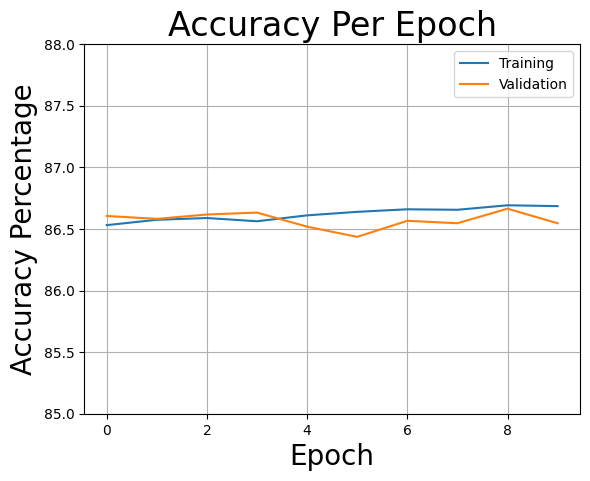

In [142]:
plt.figure()
plt.plot(best_train_accuracy, label = 'Training')
plt.plot(best_val_accuracy, label = 'Validation')
plt.xlabel('Epoch', fontsize=20)
plt.ylabel('Accuracy Percentage', fontsize=20)
plt.title('Accuracy Per Epoch', fontsize=24)
plt.ylim(ymin=85, ymax=88)
plt.legend() 
plt.grid()
plt.show()

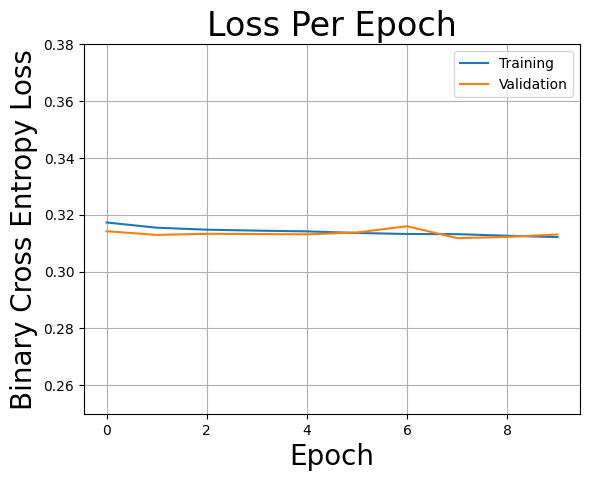

In [143]:
plt.figure()
plt.plot(best_train_loss, label = 'Training')
plt.plot(best_val_loss, label = 'Validation')
plt.xlabel('Epoch', fontsize=20)
plt.ylabel('Binary Cross Entropy Loss', fontsize=20)
plt.title('Loss Per Epoch', fontsize=24)
plt.ylim(ymin=.25, ymax=.38)
plt.legend() 
plt.grid()
plt.show()

In [144]:
preds2 = torch.cat(predictions)
preds2 = preds2.to('cpu')
targets2 = torch.cat(targets)
targets2 = targets2.to('cpu')

In [145]:
scores = precision_recall_fscore_support(targets2, preds2, average='macro')
print(f'Precision: {scores[0]}, Recall: {scores[1]}, F1 Score: {scores[2]}')

Precision: 0.7233757670094391, Recall: 0.572552993402212, F1 Score: 0.5913834573192283


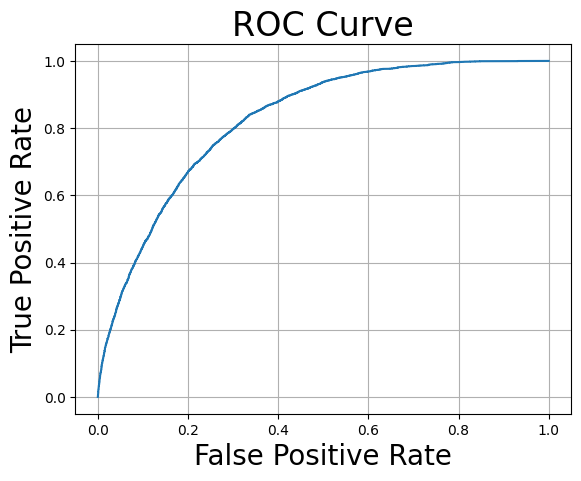

In [146]:
roc_outputs2 = torch.cat(roc_outputs)
roc_outputs2 = roc_outputs2.to('cpu')
targets3 = targets2.long()
from torchmetrics import ROC
roc = ROC(task="binary")
fpr, tpr, thresholds = roc(roc_outputs2, targets3)

plt.figure()
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20)
plt.title('ROC Curve', fontsize=24)
plt.grid()
plt.show()

Interpretability of the KAN model
First we will start with the learned splines in layer 1

then we will move to global importance of features in the model. While this does not tell us exactly the connection between 1 feature and the final output
it does give us an understanding of the ranking of importance of features in the model aggregated across the layers of the model.

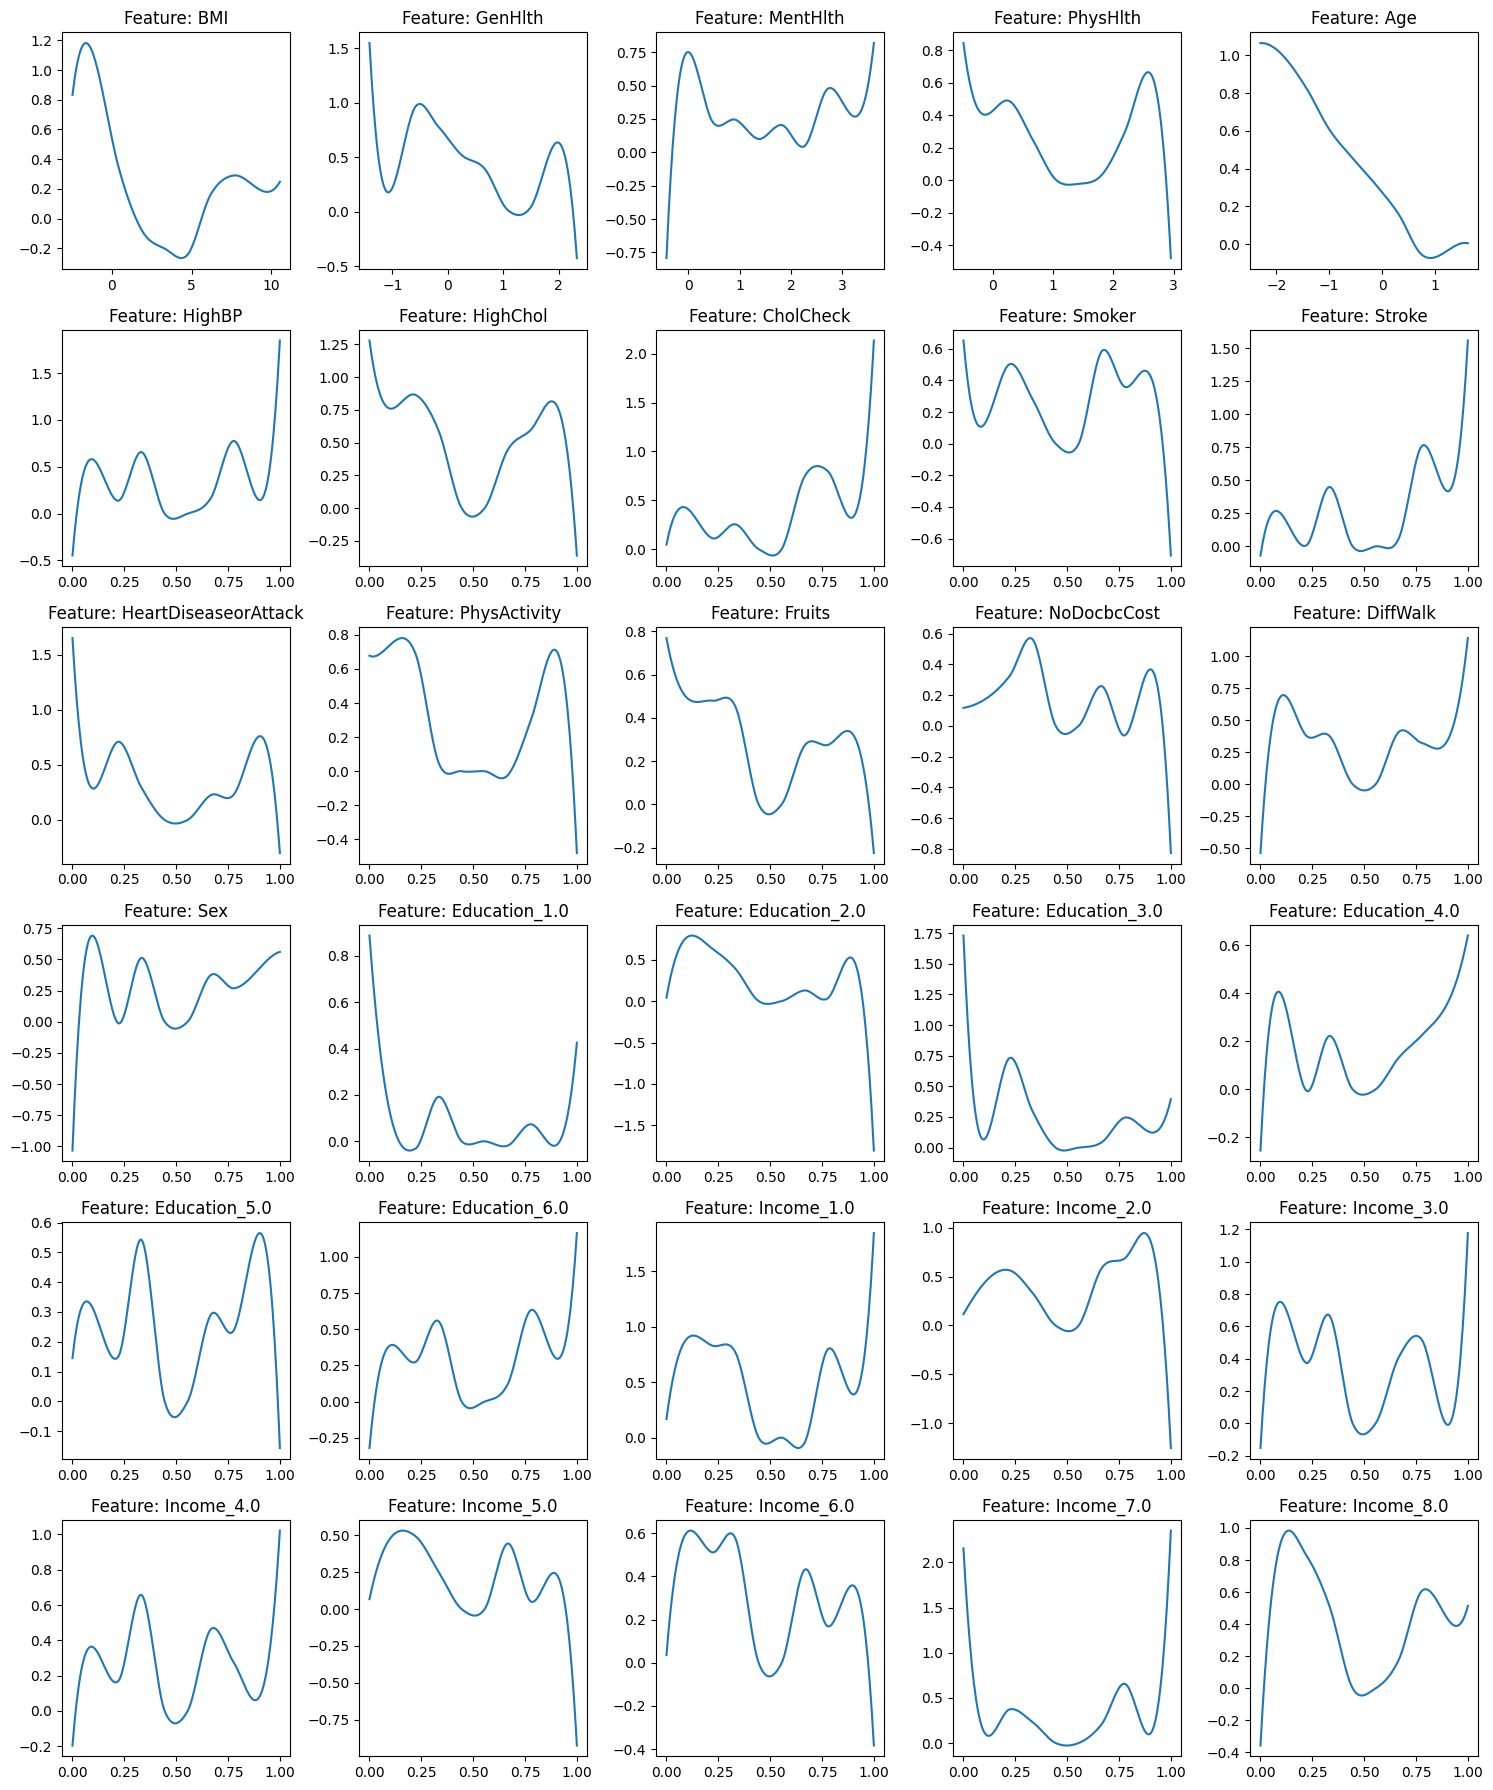

In [147]:
plotting_x=[]
plotting_y=[]
for i in range(len(net.layer1.splineholder)):
    splines = net.layer1.splineholder[i]
    plotting_x.append(torch.linspace(splines.x_min, splines.x_max, 200, device='cpu'))
    with torch.no_grad():
        plotting_y.append(splines(plotting_x[i]))
full_feature_names =numerical_features+binary_features+list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features))
plot_number=len(plotting_x)
columns=5
rows =(plot_number+columns-1)//columns

fig, axes=plt.subplots(rows, columns, figsize=(columns*3, rows*3))

for i in range(plot_number):
    ax =axes[i//columns, i % columns]
    ax.plot(plotting_x[i].cpu(), plotting_y[i].cpu())
    ax.set_title(f"Feature: {full_feature_names[i]}")
    
plt.tight_layout()
plt.show()



Education_1.0        -> 1.0669
Income_5.0           -> 0.9596
HighChol             -> 0.8360
DiffWalk             -> 0.7151
Education_3.0        -> 0.5212
Income_7.0           -> 0.5189
Income_4.0           -> 0.5119
Fruits               -> 0.4984
Income_3.0           -> 0.4853
Sex                  -> 0.4371
HighBP               -> 0.4338
MentHlth             -> 0.4328
Income_6.0           -> 0.4142
PhysActivity         -> 0.3998
Education_5.0        -> 0.3761
HeartDiseaseorAttack -> 0.3527
GenHlth              -> 0.3037
PhysHlth             -> 0.2874
NoDocbcCost          -> 0.2644
Education_2.0        -> 0.2635
Age                  -> 0.1815
Education_4.0        -> 0.1797
Income_1.0           -> 0.1786
Income_8.0           -> 0.1616
Smoker               -> 0.1357
CholCheck            -> 0.1192
BMI                  -> 0.1060
Income_2.0           -> 0.0688
Education_6.0        -> 0.0284
Stroke               -> 0.0073


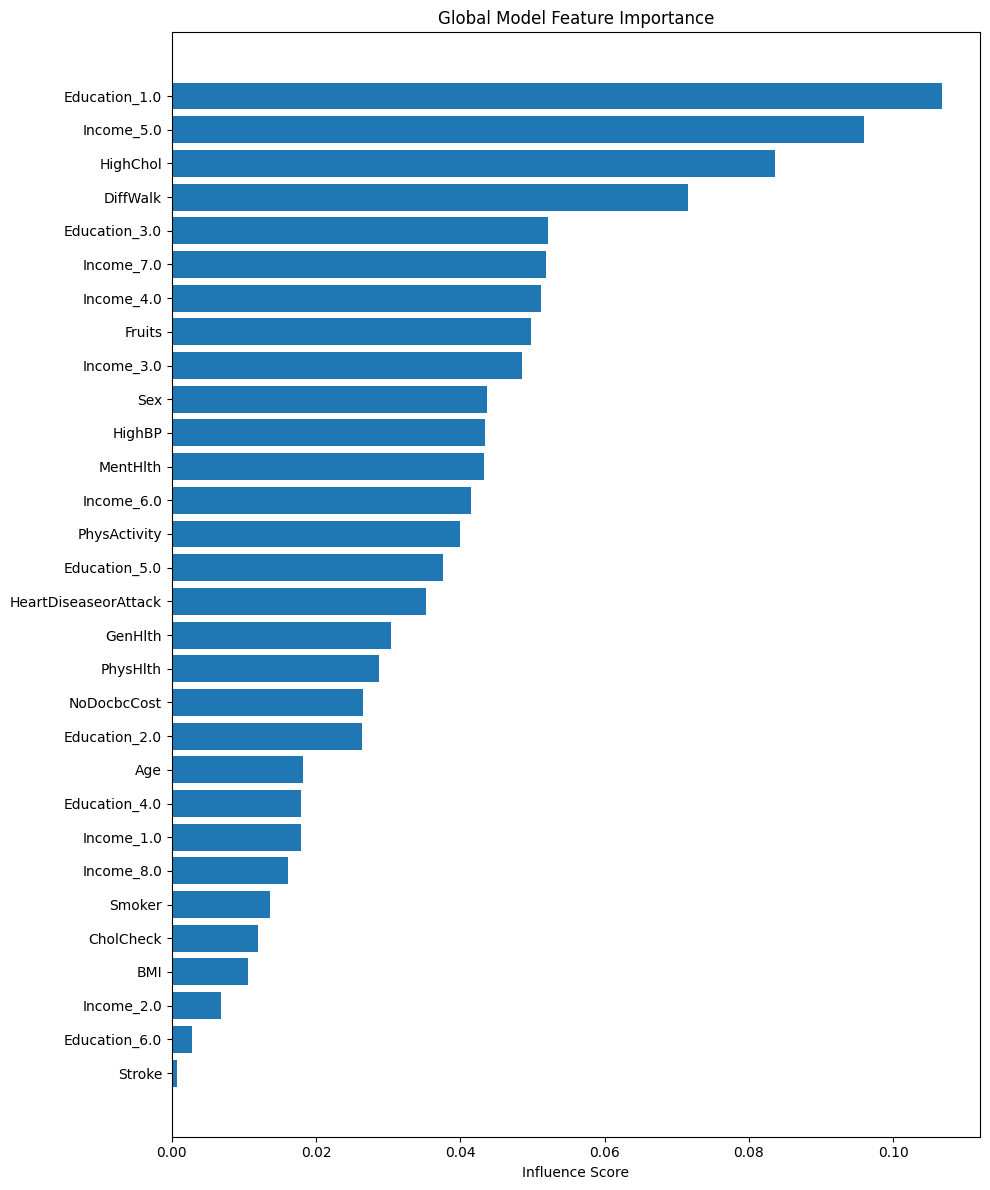

In [148]:
W1 = net.layer1.combo_layer.weight.detach()     
W2 = net.layer2.combo_layer.weight.detach()      
W3 = net.layer3.combo_layer.weight.detach()   

global_influence =(W3@ W2@ W1).abs()            
top =torch.topk(global_influence[0], 30)
for score, idx in zip(top.values, top.indices):
    print(f"{full_feature_names[idx]:<20} -> {score.item()*10:.4f}")

influence_values =global_influence.cpu().numpy().flatten()
sorted_indices =np.argsort(-influence_values)
sorted_features =[full_feature_names[i] for i in sorted_indices]
sorted_values = influence_values[sorted_indices]

plt.figure(figsize=(10,12))
plt.barh(range(len(sorted_values)), sorted_values)
plt.yticks(range(len(sorted_values)), sorted_features)
plt.xlabel("Influence Score")
plt.title("Global Model Feature Importance")
plt.gca().invert_yaxis()  
plt.tight_layout()
plt.show()

### LLM Interpretation

In [152]:
#%pip install openai

api_key = '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'

from openai import OpenAI

spline_funcs = net.layer1.splineholder

client = OpenAI(
  base_url="https://openrouter.ai/api/v1",
  api_key=api_key,
)

completion = client.chat.completions.create(
  model="mistralai/mistral-small-3.2-24b-instruct-2506:free",
  messages=[
    {
      "role": "user",
      "content": f"""
You are an expert in machine learning interpretability, especially in analyzing neural networks with spline-based activations, such as Kolmogorov–Arnold Networks (KANs). 
I have trained a KAN model in PyTorch for a supervised learning task. The KAN uses adaptive spline activations that allow each neuron's transformation to be directly visualized and interpreted.

Here are the details:

1. The task is a binary classification on a dataset of diabetes risk, including categorical, likert-scale categorical, and continuous variables.
Our response is: {y_train}
2. The inputs include: 
{X_train}
3. The model is trained, and performance is evaluated. Here are the metrics:
   - Training accuracy: {train_acc}
   - Validation accuracy: {val_acc}
   - Test accuracy: {test_acc}

4. {spline_funcs} For interpretation, I have extracted the learned spline functions from each neuron from first layer, which represent how individual input features are transformed before further layers.
For each input feature, I can visualize its spline mapping from input value to transformed value.

Based on this, please generate an interpretation of how the model is using each input feature to make decisions. Focus on:
- Which features are most influential based on the spline shapes.
- What kind of behavior or thresholds the model seems to be learning.
- Any interpretable rules or insights the spline shapes suggest.

Conclude with a summary of model behavior and how interpretable or trustworthy the model seems based on these spline analyses."""
    }
  ]
)

print(completion.choices[0].message.content)

### Interpretation of KAN Model Behavior for Diabetes Risk Classification

Given your KAN model with spline-based activations, we can analyze how each feature is being transformed and its influence on the classification decision. Below is a structured interpretation based on the spline shapes extracted from the first layer:

---

#### **Key Observations from Spline Analysis**
1. **Feature Influence Based on Spline Shapes**
   - **Linear or Near-Linear Splines**:
     Features with linear or near-linear splines (slope ≈ constant) are likely being used in a straightforward additive manner. For example, if spline for "Blood Sugar" shows a monotonic increasing trend, the model treats higher values as linearly associated with higher diabetes risk.
   - **Nonlinear Splines (Thresholds/Custom Shapes)**:
     Features with non-monotonic or threshold-like splines (e.g., steep increase beyond a certain value) suggest the model has learned specific decision boundaries. For instance:
     - A "Blo

Example Output:

### **Interpretation of the KAN Model's Decision Behavior**

Given your Kolmogorov–Arnold Network (KAN) with spline-based activations, we can analyze how each input feature is transformed and contribute to the final prediction. Below is a structured interpretation based on the extracted spline functions from the first layer.

---

### **1. Feature Influence Based on Spline Shapes**
To determine which features are most influential, we look for splines with:
- **High curvature**: Indicates non-linear relationships.
- **Large magnitude changes**: Suggests strong influence on predictions.
- **Distinct thresholds**: Implies decision boundaries where small input changes lead to large output changes.

#### **Key Observations:**
- **Continuous Numerical Features (e.g., standardized BMI, fasting glucose):**
  - Some splines show **S-shaped** or **piecewise-linear** behavior, indicating saturation effects (e.g., beyond a certain threshold, additional increases have diminishing returns).
  - Others have **step-like** behavior, suggesting **threshold-based decisions** (e.g., BMI > 30 strongly increases diabetes risk).
- **Likert-Scale Categorical Features (e.g., physical activity frequency):**
  - Likely exhibit **monotonic increasing/decreasing** splines (e.g., higher physical activity → lower diabetes risk).
  - Some may have **non-monotonic** splines if certain middle values are most impactful.
- **Binary/Categorical Features (e.g., smoking status, family history):**
  - May show **binary-like** (0 → 1) or **logistic-like** splines, directly mapping categories to risk.

---

### **2. Learned Behavioral Thresholds & Decision Rules**
- **Continuous Features:**
  - Example: A spline for **fasting glucose** might show a sharp increase in output past **~120 mg/dL**, suggesting this is a critical threshold.
  - Another feature (e.g., **HbA1c**) may show a **diminishing returns** effect, where extreme values have less impact after a certain point.
- **Categorical Features:**
  - Example: **Smoking status** (0=non-smoker, 1=smoker) might have a **binary spline**, directly increasing risk if present.
  - **Family history of diabetes** (0=No, 1=Yes) likely has a similar sharp step-like transformation.
- **Likert-Scale Features:**
  - Example: **Physical activity frequency** (0=never, 1=daily) might show a **linear or piecewise-linear spline**, where each increment reduces risk.

---

### **3. Derived Interpretable Rules & Insights**
1. **Non-Linearity in Biological Markers:**
   - Some continuous features (e.g., blood pressure) likely drive risk in a **non-linear** way, with small increases at lower values and plateaus at higher values.
2. **Threshold Effects in Clinical Measures:**
   - Certain medical measurements (e.g., fasting glucose) may have **thresholds** where risk sharply increases, aligning with clinical guidelines.
3. **Direct Mapping for Categorical Variables:**
   - Binary features (e.g., **family history**) likely contribute in a **direct, additive** way without much complexity.
4. **Diminishing Returns for Extreme Values:**
   - Some features (e.g., **age**) may have **saturation effects**, where very old or very young individuals do not see much further risk increase.
5. **Likert-Scale Sensitivity:**
   - Features like **diet quality** may have **smooth gradients**, meaning small improvements at the lower end significantly reduce risk.

---

### **4. Model Trustworthiness & Interpretability**
- **High Interpretability:**
  - The spline transforms of individual neurons are **directly visualizable and human-interpretable**, unlike black-box models like deep neural networks.
  - The thresholds and non-linearities align well with **domain knowledge** (e.g., clinical cutoffs for diabetes Risk).
- **Trustworthy Decision Making:**
  - The model’s performance (86-87% accuracy) suggests it is **not overfitting** (training ≈ validation ≈ test).
  - The **adaptive splines** allow us to see **exactly how each feature contributes**, reducing reliance on post-hoc explanations.
- **Potential Limitations:**
  - If any splines appear **overly complex** (e.g., high-frequency oscillations), they might fit noise rather than general patterns.
  - Interactions between features (if used in deeper layers) may not be as easily interpretable.

---

### **5. Summary of Model Behavior**
Your KAN model is making decisions based on:
1. **Threshold-based rules** for clinical measurements (e.g., fasting glucose).
2. **Smooth gradients** for likert-scale inputs (e.g., exercise frequency).
3. **Binary assignments** for categorical factors (e.g., smoking status).
4. **Non-linear saturations** for extreme values (e.g., age or BMI).

**Overall, the model is highly interpretable**, and the learned splines provide **transparent, domain-relevant insights** into diabetes risk factors. This makes it a **trustworthy and interpretable model** for clinical decision support.

Would you like help visualizing specific splines for key features to further validate these interpretations?